## 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음|OK|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|OK|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨.|OK|


### dataset
1. Tesla(TSLA) stock
2. Kakao stock
3. NAVER stock

### 적용할 알고리즘
1. ARIMA model

### 성능 평가 지표  
1. MAPE(Mean Absolute Percentage Error)


## 문제 정의  

> 3 종목 주식을 ARIMA model를 적용하여 예측  
> 성능 평가 지표로 MAPE 15% 미만 만족 

## 분석 결과  



|Evaluation|TSLA|Kakao|NAVER| 
|:---------:|:----------:|:----------:|:--:|
|MAPE|9.35 %|2.50 %|4.13 %|

## 분석환경

In [87]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.4.4
1.0.2
0.13.2


# 주식 종목 예측 1 - TSLA

## STEP 1: 시계열 데이터 준비

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = './data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df
ts

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-15,317.736664,326.250000,309.416656,325.329987,325.329987,75169200
2021-12-16,331.500000,331.660004,307.283325,308.973328,308.973328,82771500
2021-12-17,304.923340,320.220001,303.013336,310.856659,310.856659,100437300
2021-12-20,303.566681,307.230011,297.796661,299.980011,299.980011,56480100
2021-12-21,305.623322,313.166656,295.373322,312.843323,312.843323,71517900
...,...,...,...,...,...,...
2022-12-08,172.199997,175.199997,169.059998,173.440002,173.440002,97624500
2022-12-09,173.839996,182.500000,173.360001,179.050003,179.050003,104746600
2022-12-12,176.100006,177.369995,167.520004,167.820007,167.820007,109794500


Date
2021-12-15    325.329987
2021-12-16    308.973328
2021-12-17    310.856659
2021-12-20    299.980011
2021-12-21    312.843323
                 ...    
2022-12-08    173.440002
2022-12-09    179.050003
2022-12-12    167.820007
2022-12-13    160.949997
2022-12-14    156.800003
Name: Close, Length: 252, dtype: float64

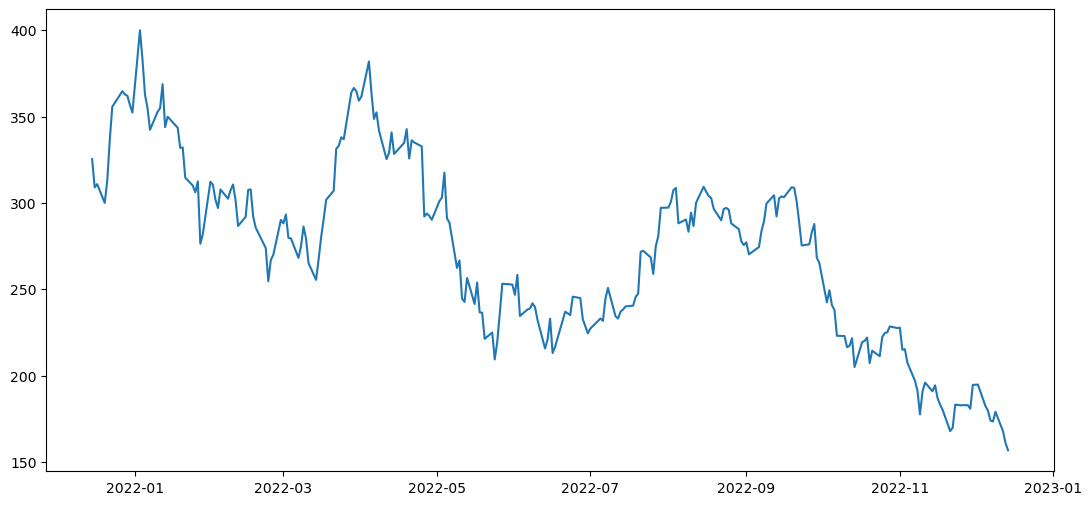

In [89]:
plt.plot(ts)

* 직관적으로 보면, 평균과 분산이 일정하지 않음

## SETP 2 : 각종 전처리 수행

* NAN이 있는 경우 interploate(보간) 하여 대입 

In [90]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

* 분산이 일정하지 않는 경우 자연로그 변환

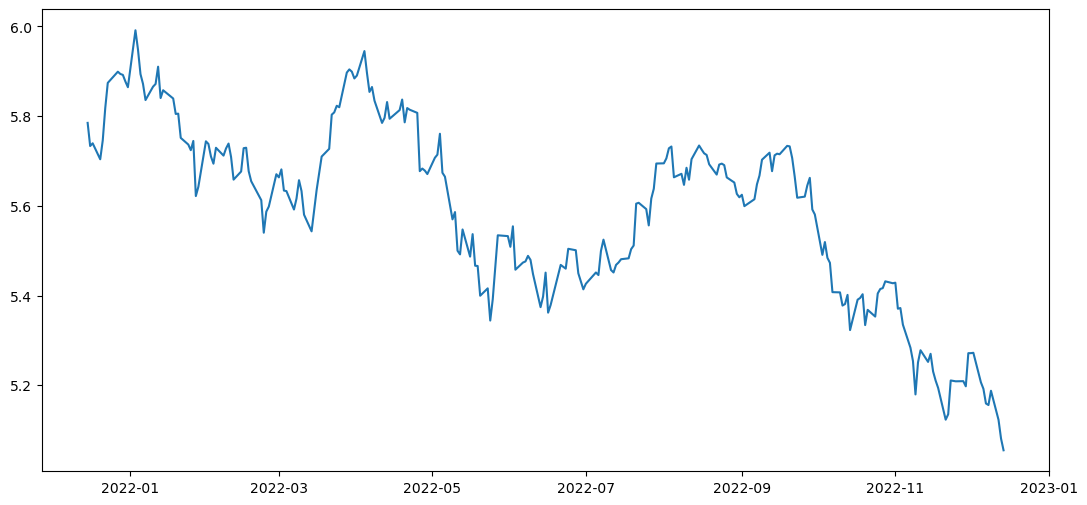

In [91]:
# 로그 변환 시도 
ts_log = np.log(ts)

plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [92]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [93]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

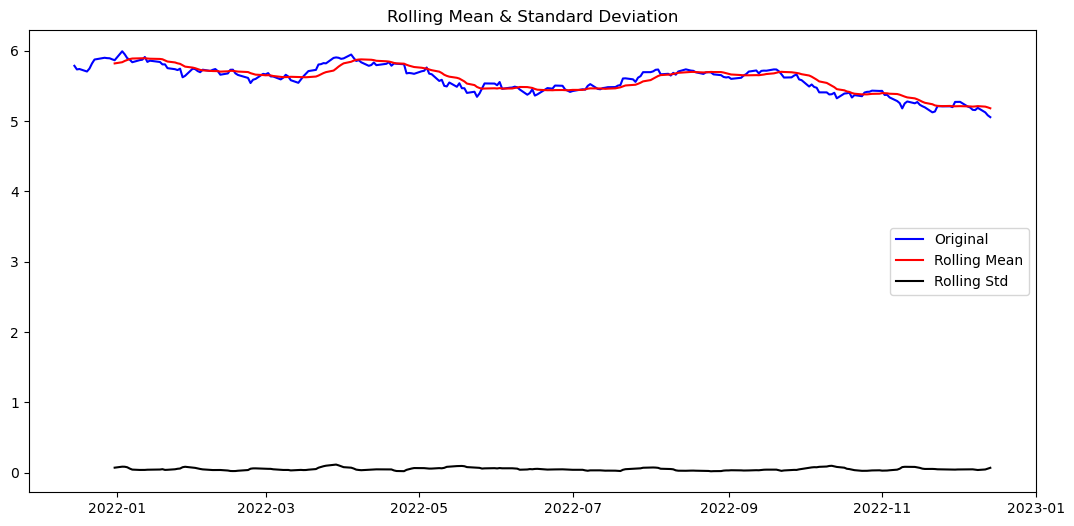

Results of Dickey-Fuller Test:
Test Statistic                  -1.007978
p-value                          0.750344
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

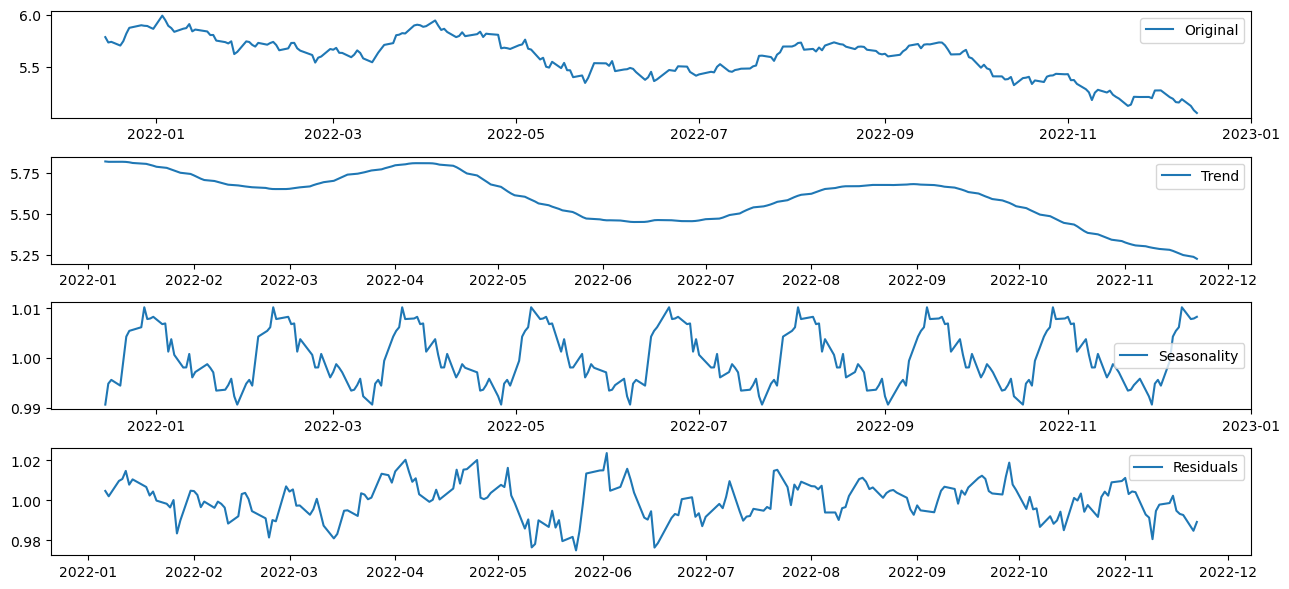

In [94]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

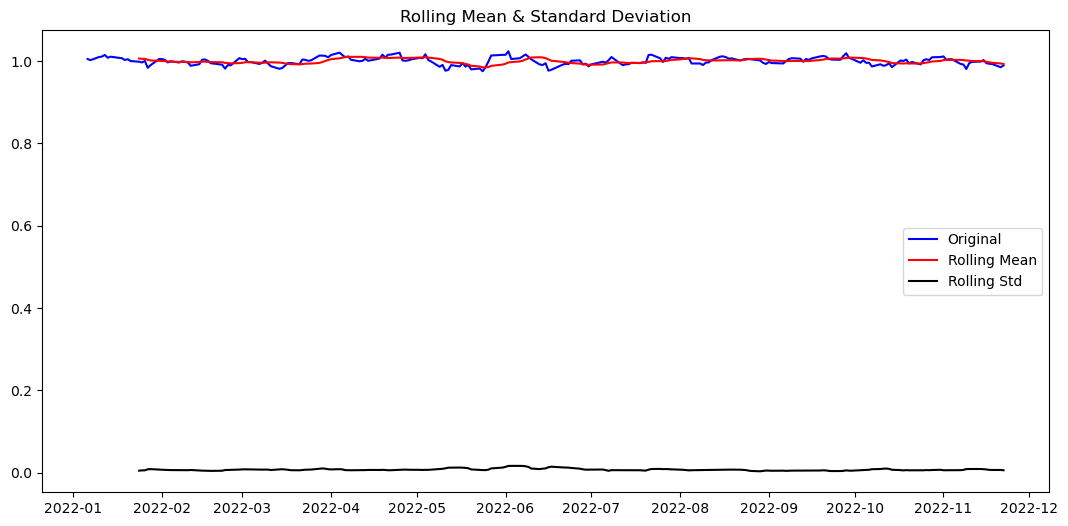

In [95]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [96]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.173790
p-value                          0.000010
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


* Residual P-value가 0에 가까우므로, stationary한 시계열임이 증명됨

## STEP 4 : 학습, 테스트 데이터셋 생성

<Figure size 1000x600 with 0 Axes>

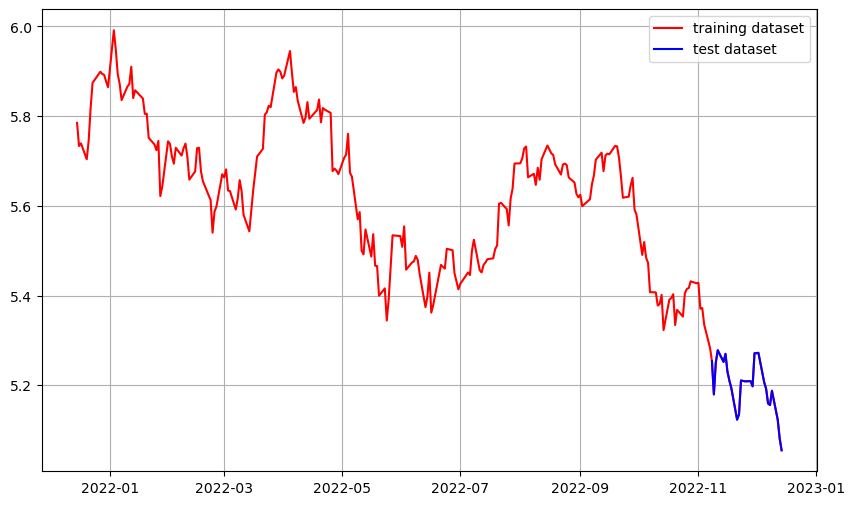

In [97]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기  
* 차분 안정성 확인 -> d 구하기


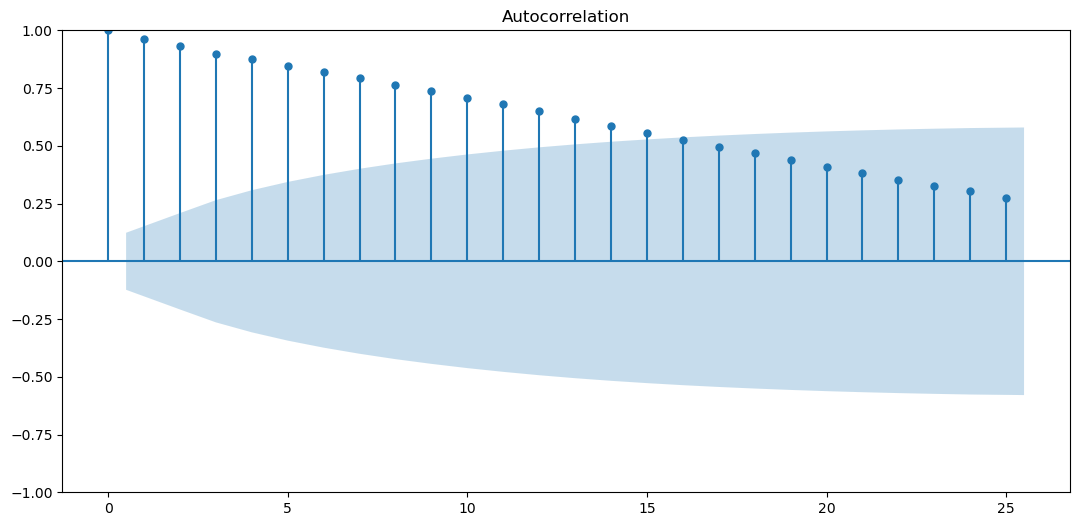

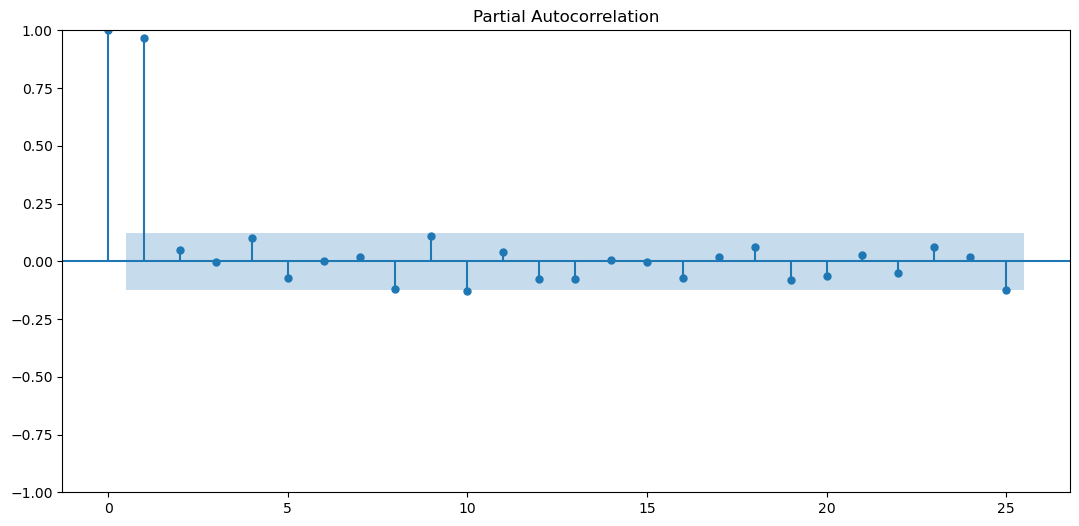

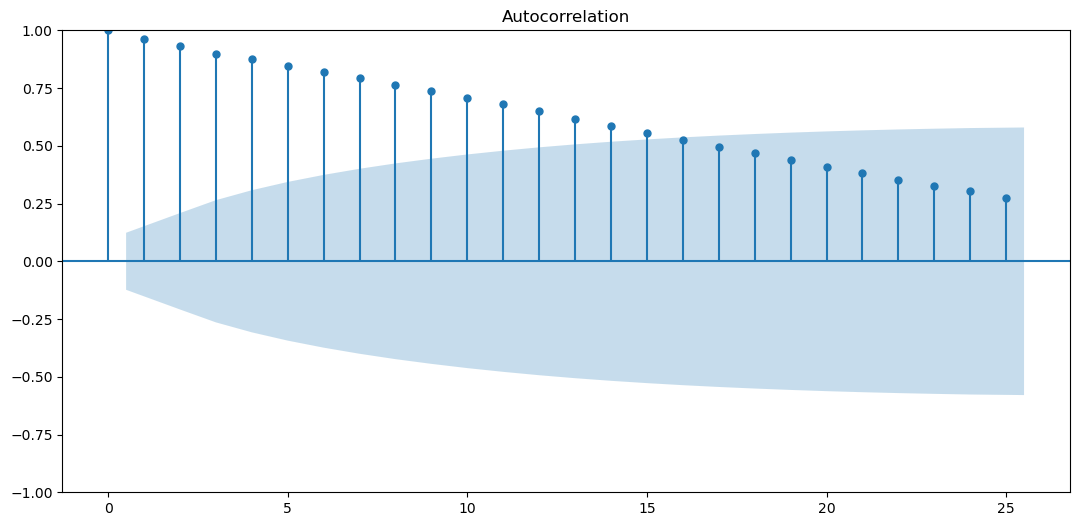

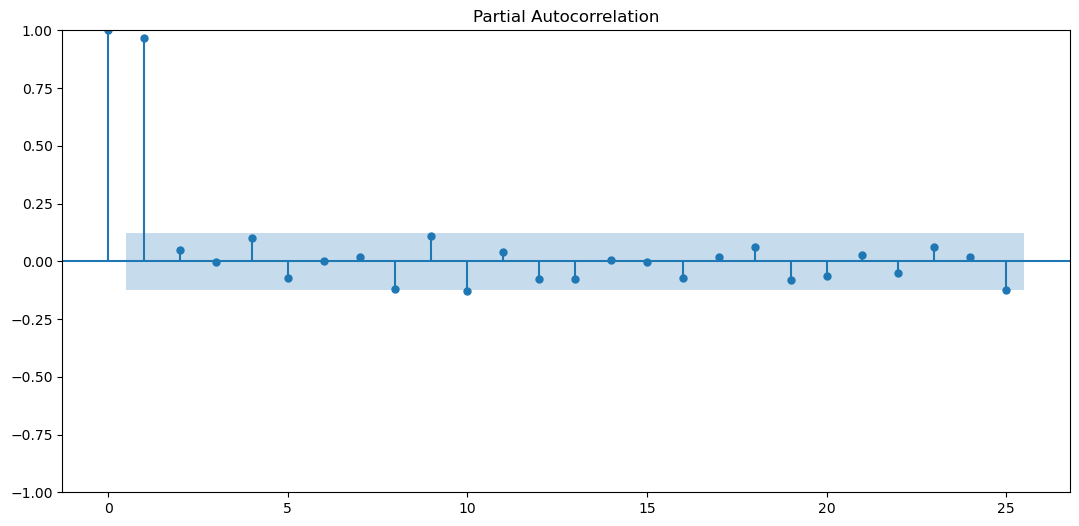

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* AR(1) 모델에 유사한 형태로 보임
  * PACF : 시차 p=1 이후에 0
  * ACF : 점차적으로 감소

<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Date'>

Results of Dickey-Fuller Test:
Test Statistic                  -4.698356
p-value                          0.000085
#Lags Used                       9.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


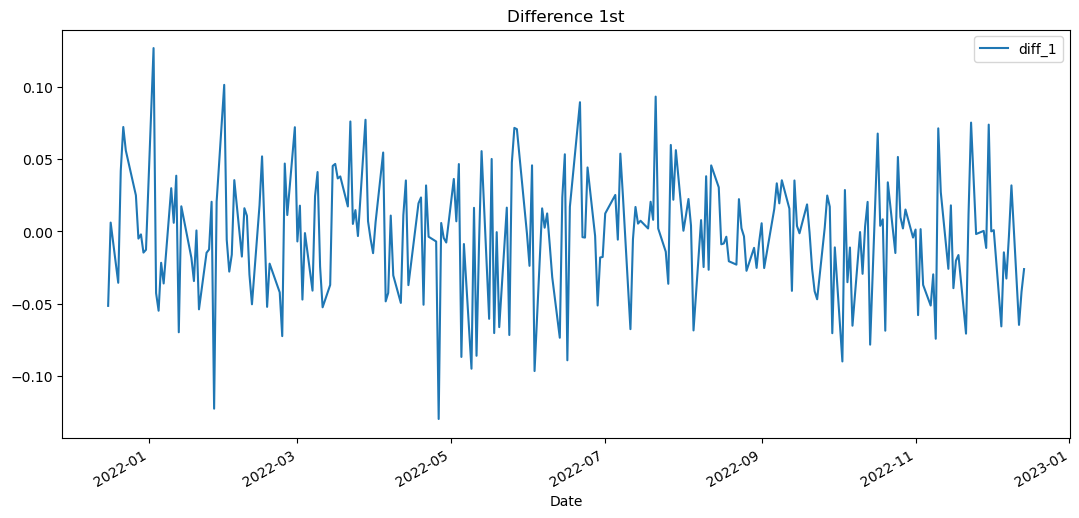

In [99]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st',label='diff_1')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd',label='diff_2')

#augmented_dickey_fuller_test(diff_2)

plt.legend()
plt.show()

* d = 1  
1 차 차분 후에 p-value 0에 가까움

## STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [115]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  

fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 399.166
Date:                Tue, 20 Dec 2022   AIC                           -794.333
Time:                        23:24:22   BIC                           -787.501
Sample:                             0   HQIC                          -791.575
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0655      0.084     -0.779      0.436      -0.230       0.099
sigma2         0.0017      0.000     11.768      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.00   Jarque-

<Figure size 1000x500 with 0 Axes>

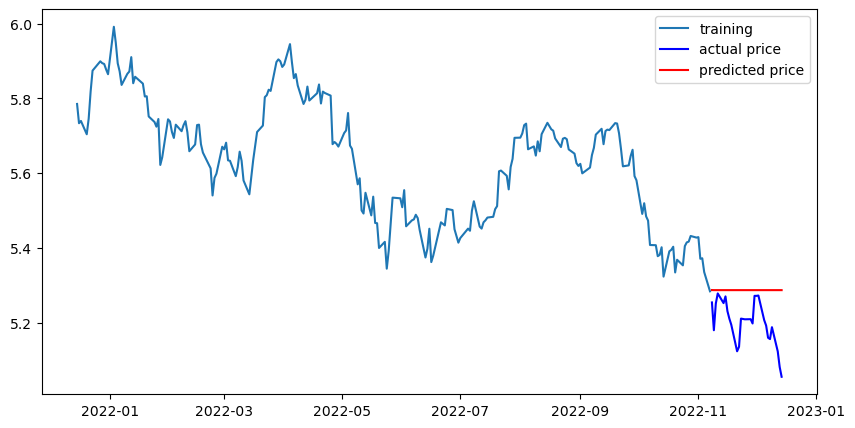

In [116]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [117]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  376.0408783896991
MAE:  16.26463800548026
RMSE:  19.39177347200867
MAPE: 9.35%


# 주식 종목 예측 2 - Kakao

## STEP 1: 시계열 데이터 준비

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = './data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df
ts

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-16,120378.765625,121386.117188,119371.414063,120378.765625,120322.960938,1160185
2021-12-17,118867.734375,119875.085938,118364.054688,118364.054688,118309.187500,1255838
2021-12-20,117356.703125,117860.382813,113830.968750,113830.968750,113778.203125,2967970
2021-12-21,113327.289063,115845.671875,113327.289063,115342.000000,115288.531250,1356910
2021-12-22,115845.671875,116349.351563,114334.640625,115342.000000,115288.531250,1028938
...,...,...,...,...,...,...
2022-12-12,57700.000000,58700.000000,57000.000000,58100.000000,58100.000000,1402888
2022-12-13,59000.000000,59700.000000,57700.000000,58200.000000,58200.000000,1532110
2022-12-14,58800.000000,59500.000000,58300.000000,58700.000000,58700.000000,1550967


Date
2021-12-16    120378.765625
2021-12-17    118364.054688
2021-12-20    113830.968750
2021-12-21    115342.000000
2021-12-22    115342.000000
                  ...      
2022-12-12     58100.000000
2022-12-13     58200.000000
2022-12-14     58700.000000
2022-12-15     55300.000000
2022-12-16     54700.000000
Name: Close, Length: 246, dtype: float64

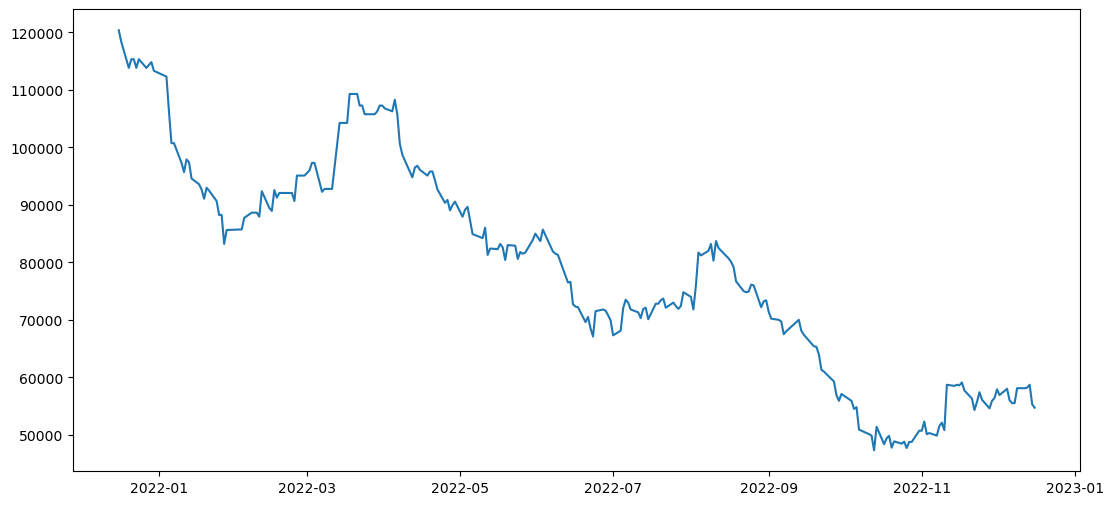

In [19]:
plt.plot(ts)

## SETP 2 : 각종 전처리 수행

In [20]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

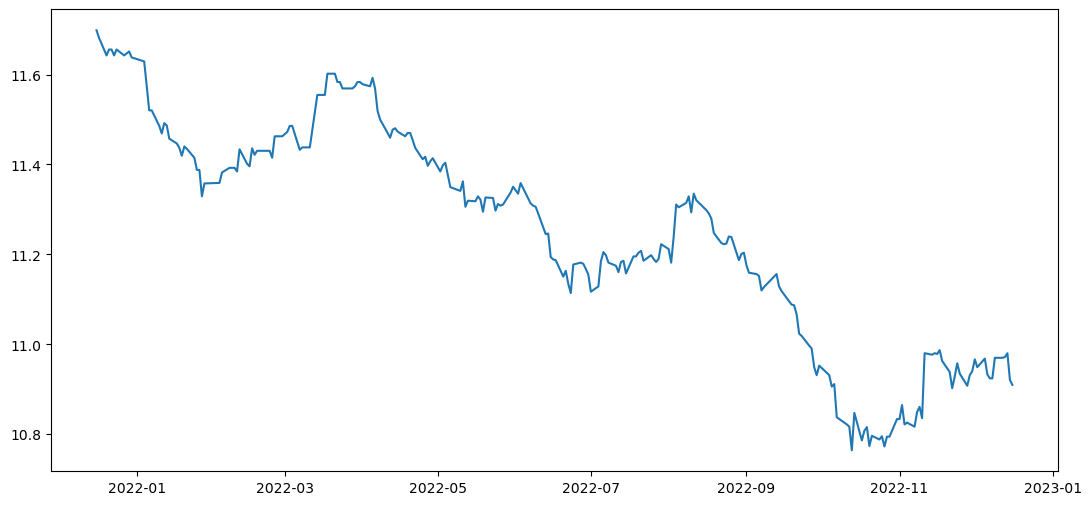

In [21]:
# 로그 변환 시도 
ts_log = np.log(ts)

plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [22]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [23]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

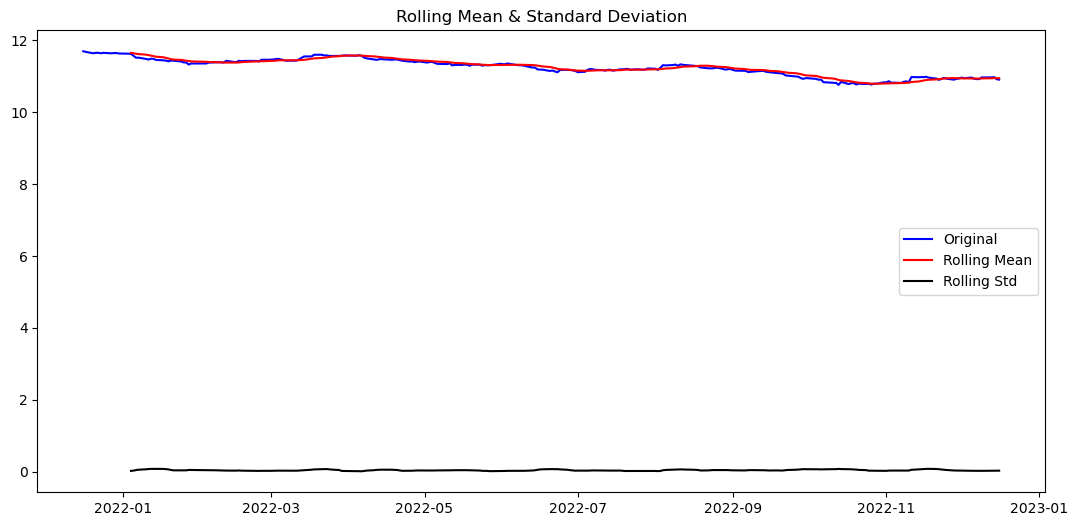

Results of Dickey-Fuller Test:
Test Statistic                  -1.152317
p-value                          0.693764
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

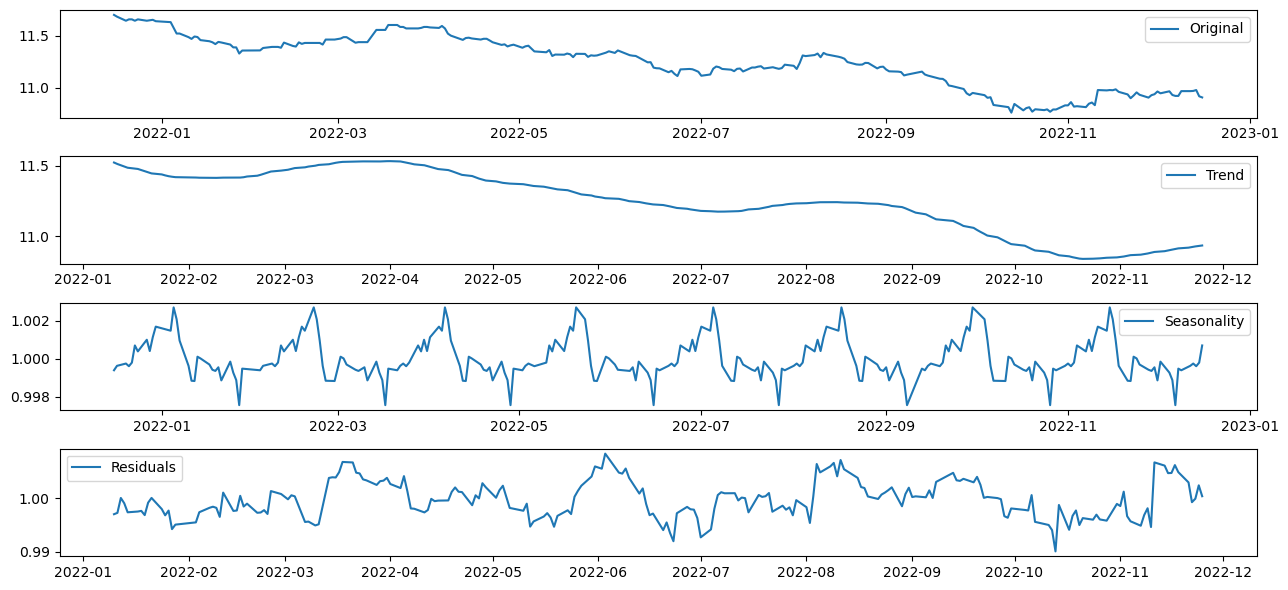

In [24]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

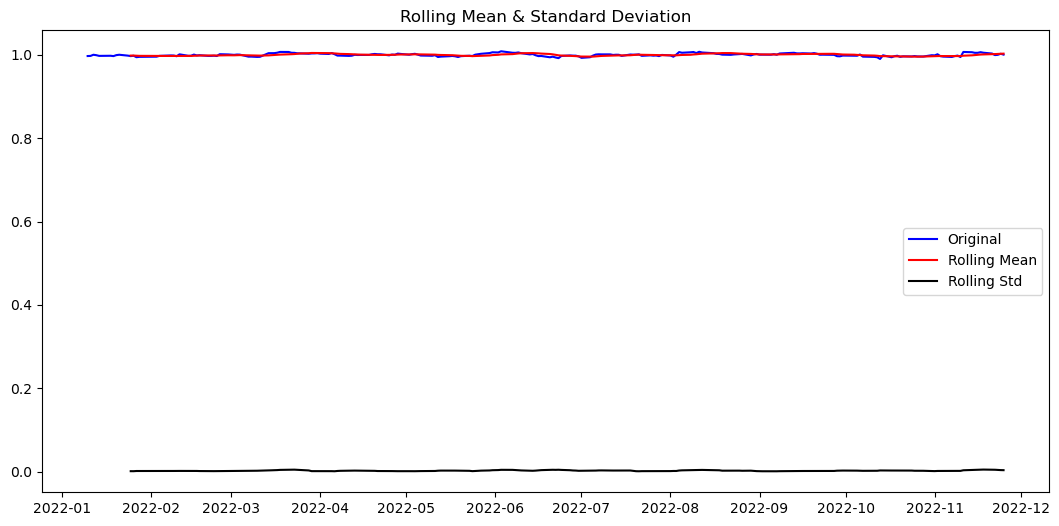

In [25]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [26]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.640635
p-value                          0.000109
#Lags Used                       3.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

<Figure size 1000x600 with 0 Axes>

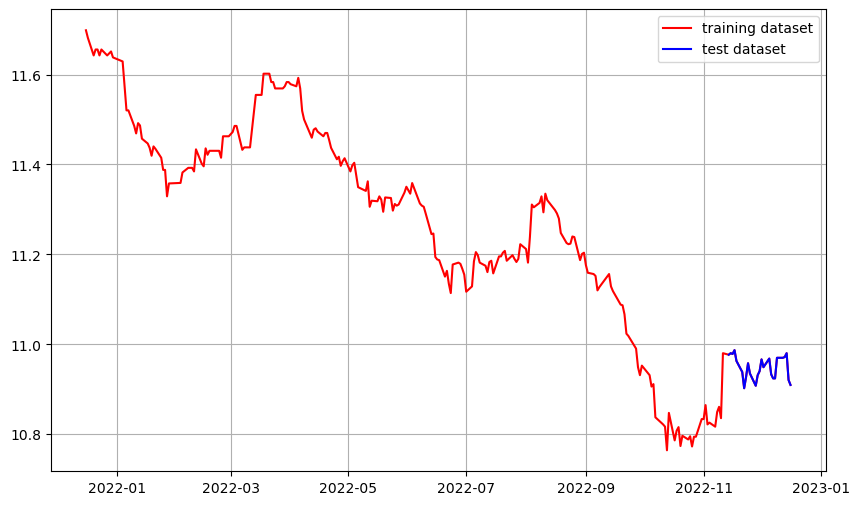

In [27]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기  
* 차분 안정성 확인 -> d 구하기


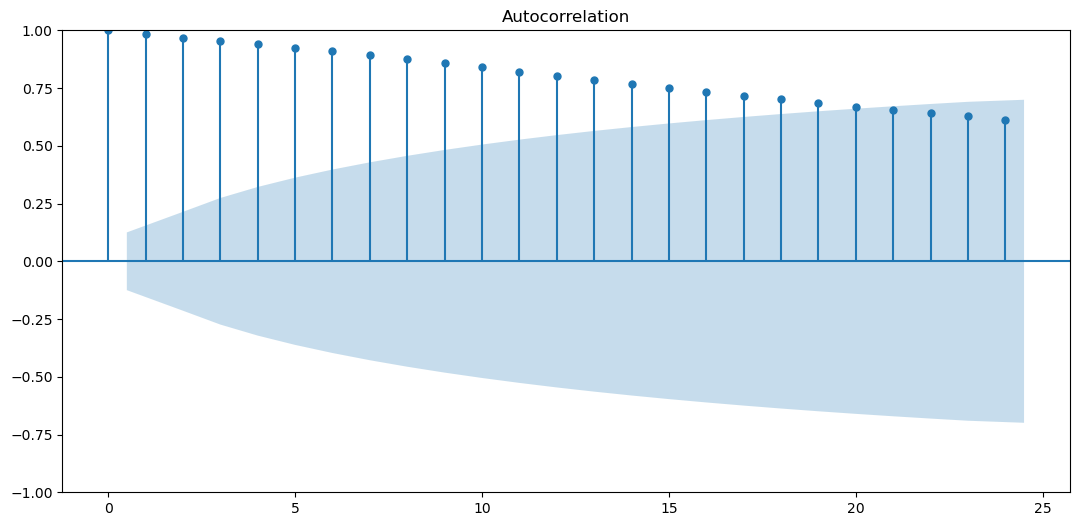

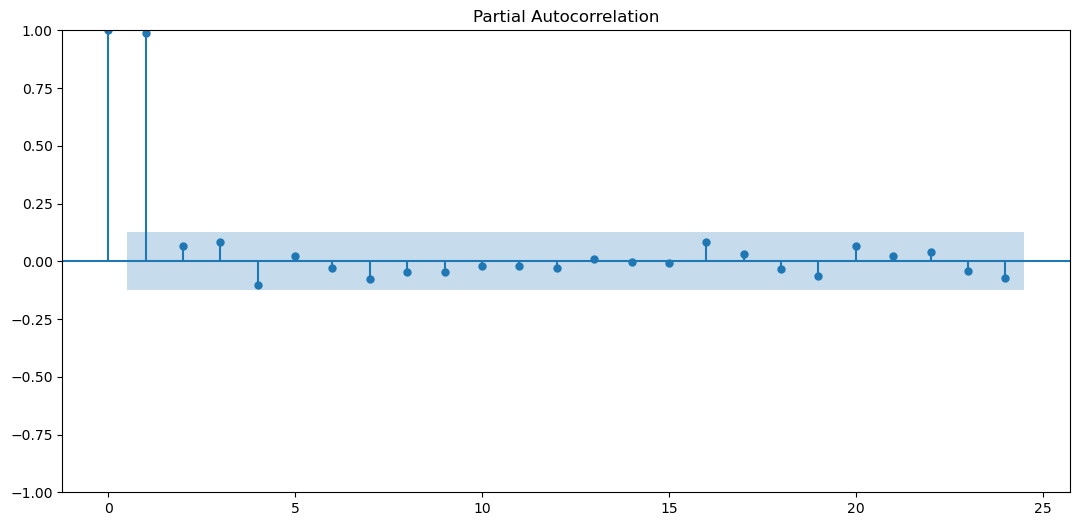

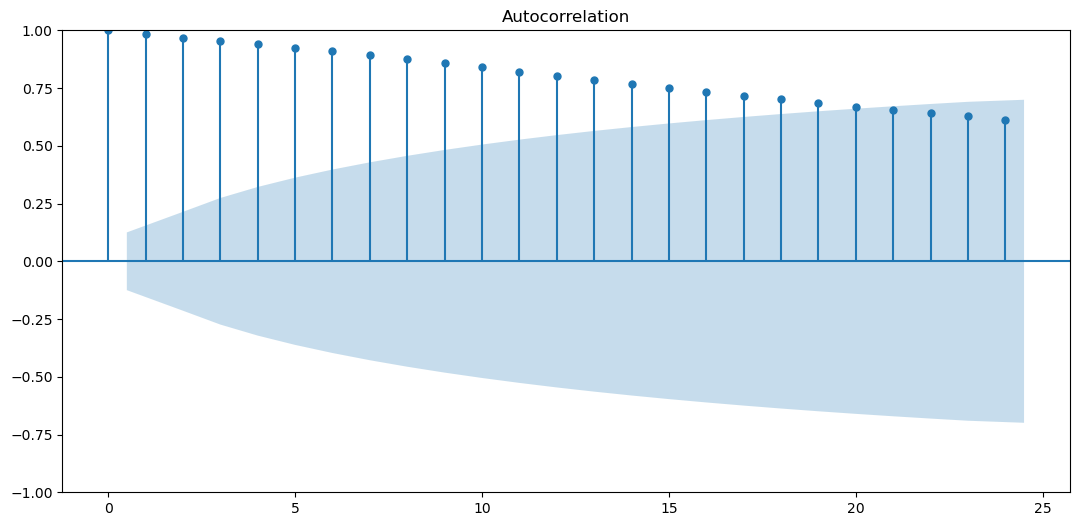

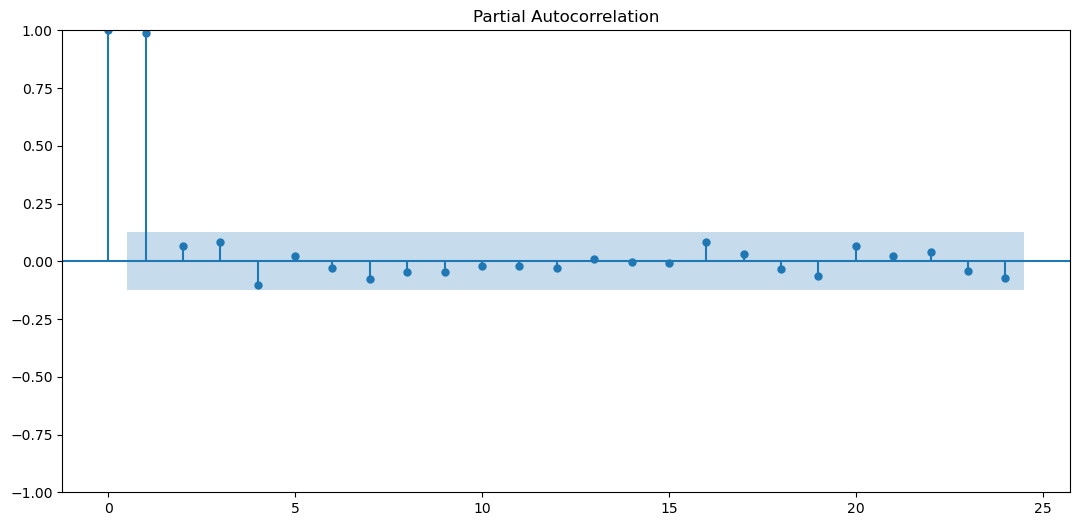

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* AR(1) 모델에 유사한 형태로 보임
  * PACF : 시차 p=1 이후에 0
  * ACF : 점차적으로 감소
  


<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Date'>

Results of Dickey-Fuller Test:
Test Statistic                -7.739606e+00
p-value                        1.070644e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


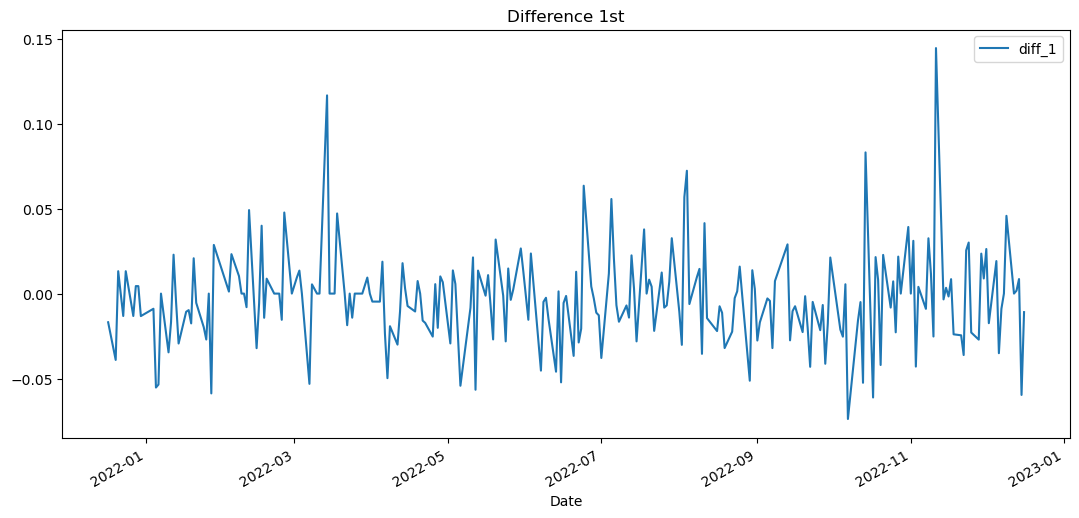

In [29]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st',label='diff_1')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd',label='diff_2')

#augmented_dickey_fuller_test(diff_2)

plt.legend()
plt.show()

* d = 1  
1차 차분 후에 p-value 0에 가까움


## STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [30]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  

fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 477.327
Date:                Tue, 20 Dec 2022   AIC                           -950.653
Time:                        23:07:53   BIC                           -943.866
Sample:                             0   HQIC                          -947.912
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1129      0.071     -1.583      0.113      -0.253       0.027
sigma2         0.0008   4.33e-05     17.633      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.07   Jarque-

<Figure size 1000x500 with 0 Axes>

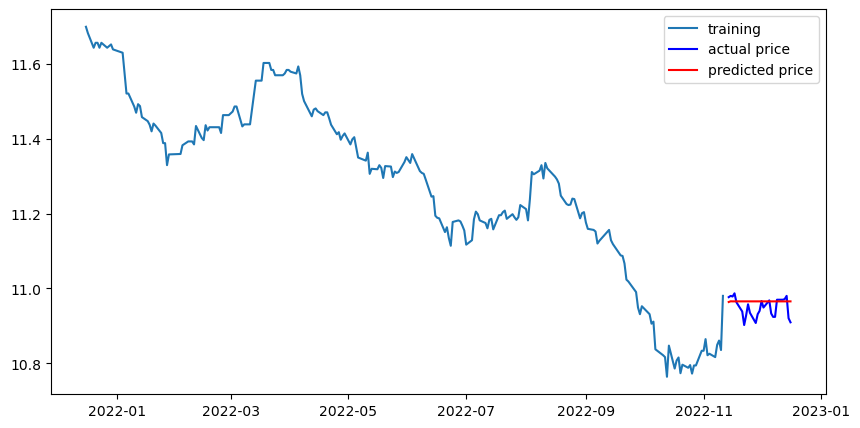

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  3014172.841730765
MAE:  1396.5792505910745
RMSE:  1736.137333775979
MAPE: 2.50%


# 주식 종목 예측 3 - NAVER

## STEP 1: 시계열 데이터 준비

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = './data/035420.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df
ts

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-16,389500.0,395500.0,384500.0,387500.0,385220.87500,543865
2021-12-17,387000.0,387500.0,383500.0,384500.0,382238.53125,505284
2021-12-20,381500.0,383000.0,373000.0,373000.0,370806.15625,630690
2021-12-21,370000.0,379000.0,370000.0,375000.0,372794.43750,480367
2021-12-22,376000.0,380000.0,375500.0,378500.0,376273.81250,263513
...,...,...,...,...,...,...
2022-12-12,192500.0,196500.0,190500.0,193000.0,193000.00000,652814
2022-12-13,195500.0,197000.0,191000.0,193000.0,193000.00000,692706
2022-12-14,194000.0,195000.0,191500.0,193500.0,193500.00000,708760


Date
2021-12-16    387500.0
2021-12-17    384500.0
2021-12-20    373000.0
2021-12-21    375000.0
2021-12-22    378500.0
                ...   
2022-12-12    193000.0
2022-12-13    193000.0
2022-12-14    193500.0
2022-12-15    182500.0
2022-12-16    181000.0
Name: Close, Length: 246, dtype: float64

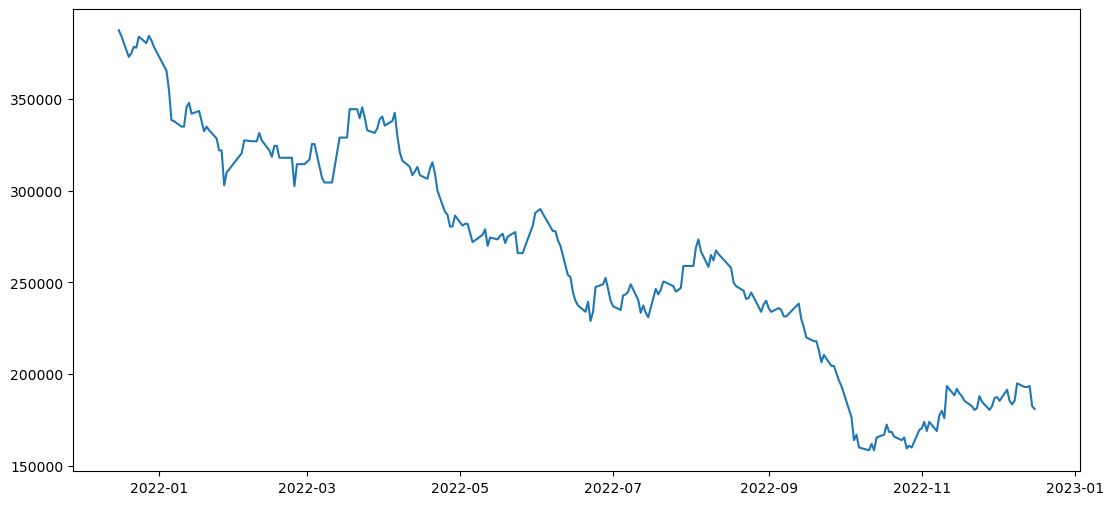

In [52]:
plt.plot(ts)

* 직관적으로 보면, 평균과 분산이 일정하지 않음

## SETP 2 : 각종 전처리 수행

* NAN이 있는 경우 interploate(보간) 하여 대입 

In [56]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

* 분산이 일정하지 않는 경우 자연로그 변환

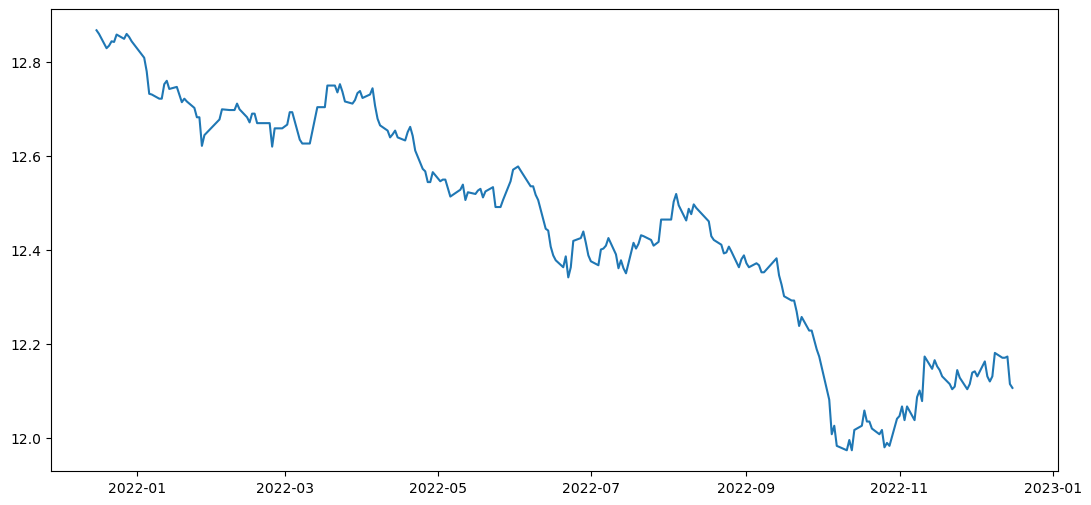

In [59]:
# 로그 변환 시도 
ts_log = np.log(ts)

plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [60]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [61]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

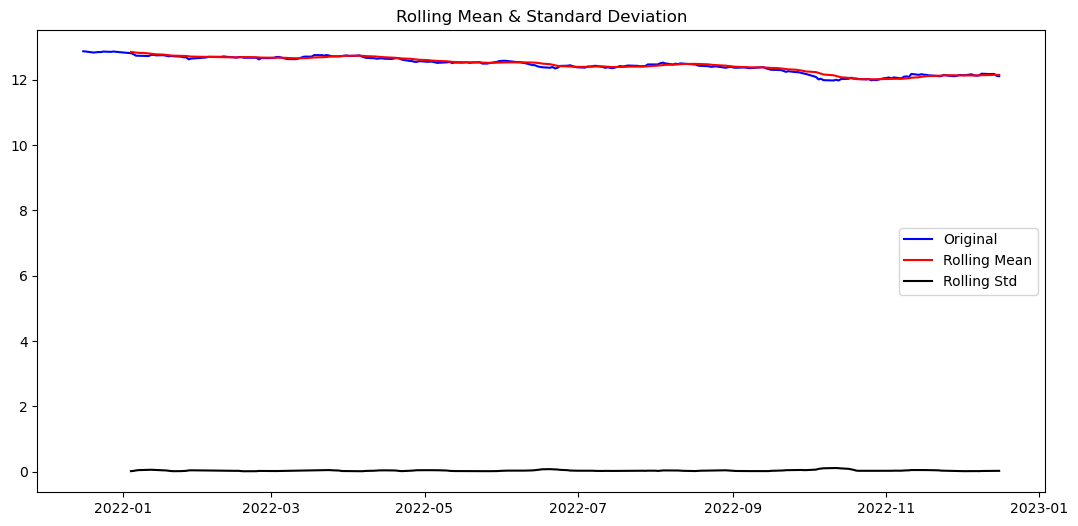

Results of Dickey-Fuller Test:
Test Statistic                  -1.063497
p-value                          0.729407
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

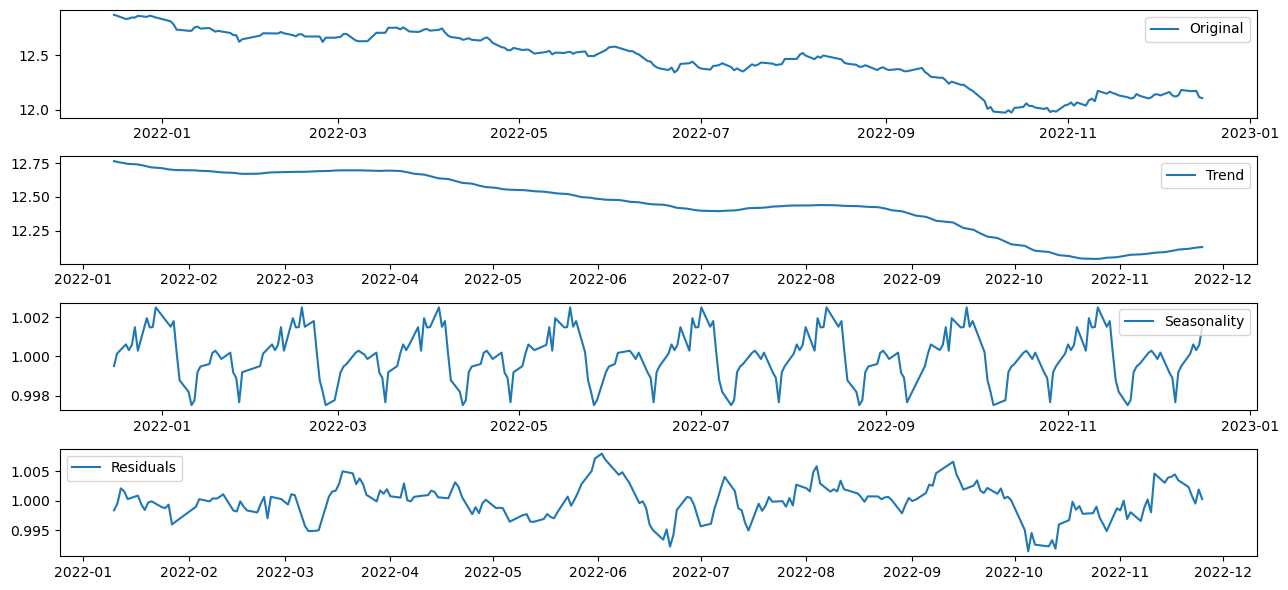

In [63]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

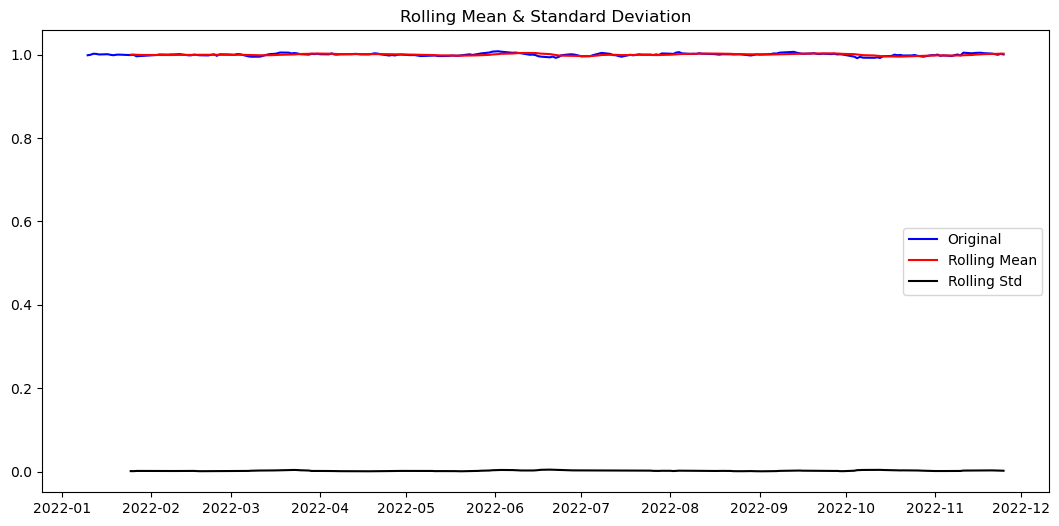

In [64]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [66]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.576109
p-value                          0.006235
#Lags Used                      14.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


* Residual P-value가 0에 가까우므로, stationary한 시계열임이 증명됨

## STEP 4 : 학습, 테스트 데이터셋 생성

<Figure size 1000x600 with 0 Axes>

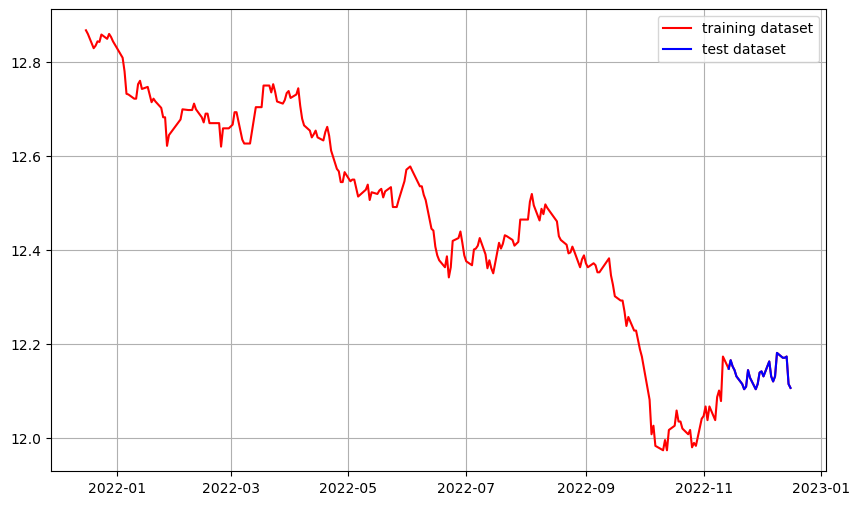

In [67]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기  
* 차분 안정성 확인 -> d 구하기


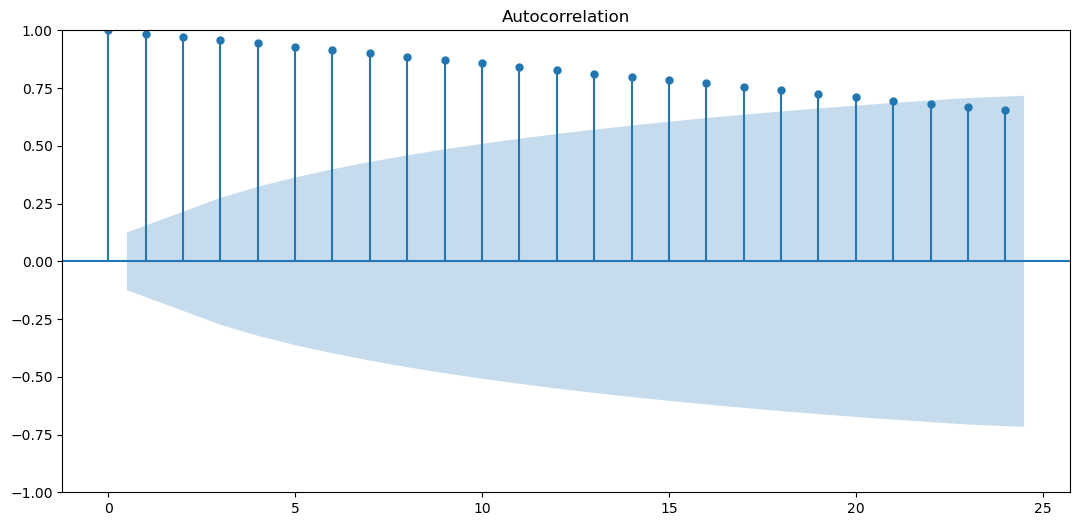

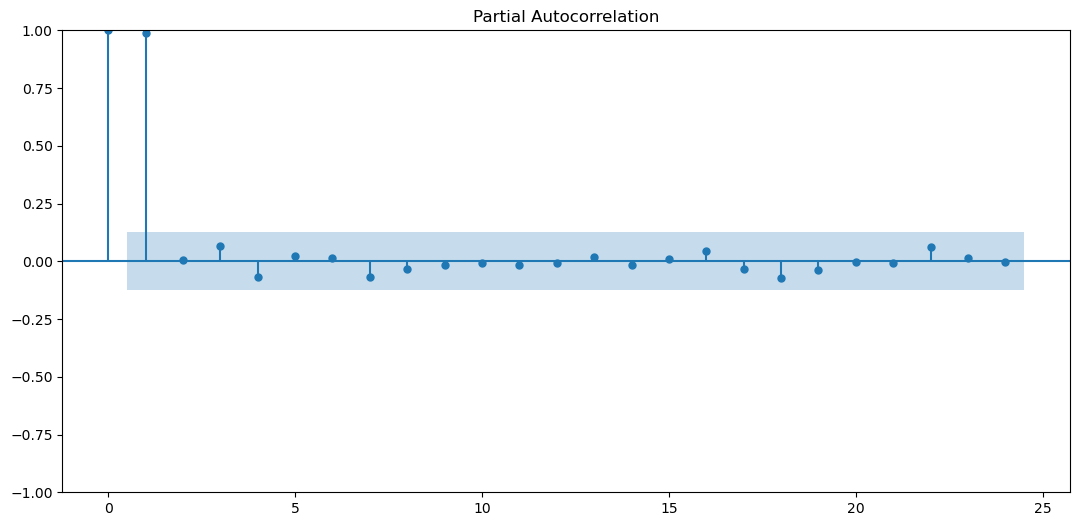

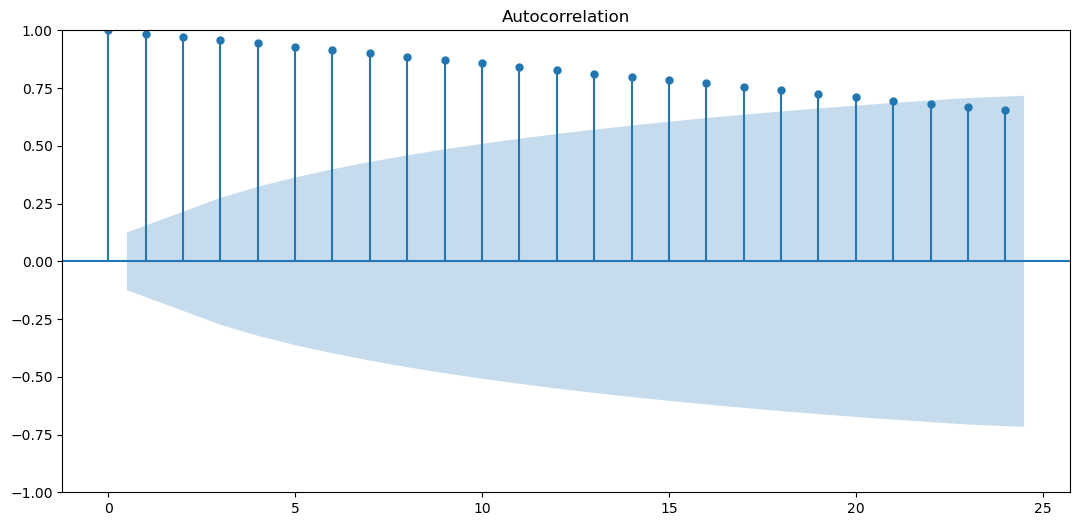

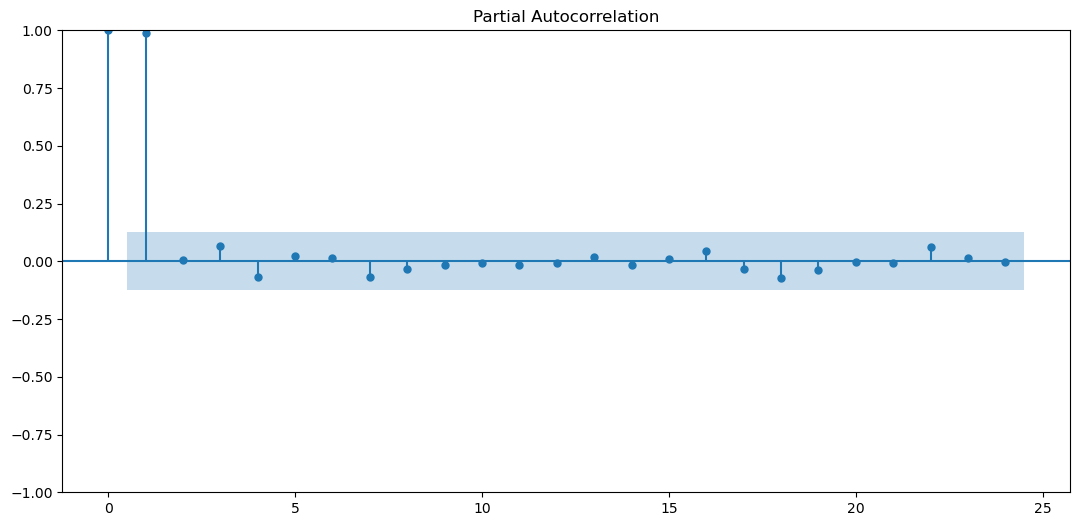

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* AR(1) 모델에 유사한 형태로 보임
  * PACF : 시차 p=1 이후에 0
  * ACF : 점차적으로 감소

<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Date'>

Results of Dickey-Fuller Test:
Test Statistic                -1.562419e+01
p-value                        1.716975e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


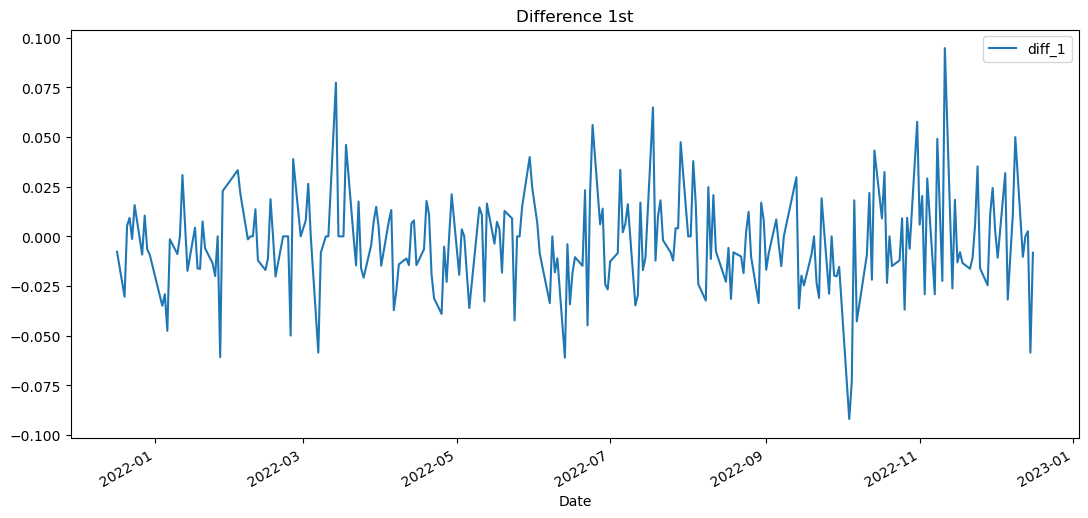

In [71]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st',label='diff_1')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd',label='diff_2')


#augmented_dickey_fuller_test(diff_2)

plt.legend()
plt.show()

* d = 1  
1차 차분 후에 p-value 0에 가까움


## STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [72]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  

fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 502.719
Date:                Tue, 20 Dec 2022   AIC                          -1001.438
Time:                        23:15:46   BIC                           -994.651
Sample:                             0   HQIC                          -998.698
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0406      0.064      0.633      0.527      -0.085       0.166
sigma2         0.0006   4.24e-05     14.287      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.09   Jarque-

<Figure size 1000x500 with 0 Axes>

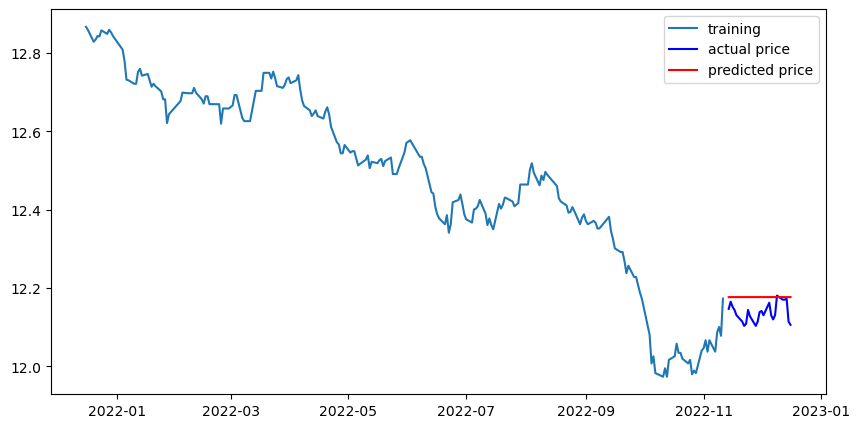

In [73]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  75873828.71233353
MAE:  7614.665877989775
RMSE:  8710.558461564535
MAPE: 4.13%


## 회고

* 시계열 그래프 해석이 어렵다. 
  * 시계열 그래프를 봤을 때, 평균이 감소, 증가하는 경우는 알겠는데, 분산이 일정하지 않는 것임을 해석하는 것은 어려움
  * 분산이 일정하지 않으면 로그변환을 해서 일정해 진다고 하는데, log 변환 후에도 log 변환 전 그래프와의 차이점을 못 찾겠음
  *ACF, PACF 그래프 해석으로 p,q 찾는 법도, 주식 종목 그래프 패턴이 모두 유사하여, p,q 값이 동일함. 좀 더 다양한 ACF, PACF 그래프를 보고 해서하는 능력을 키워야 함